## simple_gibbs.py


The following is code for a Gibbs sampler that performs MCMC estimation for the mixture model approach to record linkage, with conditional independence across comparison fields.  Details are provided below.

## Mixture model approach to record linkage

The probability of a comparison vector $\gamma$ is seen arising from a mixture distribution:

$$ Pr(\gamma) = Pr(\gamma | M ) p_M + Pr(\gamma | U) p_U $$ 

where $Pr(\gamma | M)$ and $Pr(\gamma | U)$ are the probabilities of observing the pattern $\gamma$ among matches $M$ and non-matches $U$, and $p_M$ and $p_U = 1 - p_M$ are the proportion of matched and unmatched pairs in the population.  

Assuming conditional independence across comparison fields  reduces the number of parameters within each mixture class from $2^K -1 $ parameters to $K$: 

$$ Pr(\gamma | C) = \prod_{k=1}^K Pr(\gamma_k | C)^{\gamma_k}(1-Pr(\gamma_k| C)^{1-\gamma_k} $$ 
for $C\in\{M,U\}$. 

## Gibbs Sampling
### Basic setup (within blocks, binary comparisons)

Following Larsen (2012), I estimate the parameters of the mixture model approach to record linkage via Gibbs Sampling as follows:

1. Using the current values of $(p_M^{(k)}, p_{M\ell}^{(k)}, p_{U\ell}^{(k)})$, draw the components of $I^{(k+1)}$ independently from $$ Pr(\ I(a,b)^{(k+1)}=1\ |\ \gamma(a,b)) = Pr(\ M\  |\  \gamma(a,b)) = \frac{p_M^{(k)}Pr(\ \gamma(a,b)\ |\ M)}{Pr(\gamma(a,b))} $$ where $$Pr(\gamma(a,b)\ |\ M) = \prod_{\ell}  (p_{M\ell}^{(k)})^{\gamma_{\ell}(a,b)}(1-p_{M\ell}^{(k)})^{1-\gamma_{\ell}(a,b)}$$ and the denominator is calculated according to formula above. 
<p>

2. Draw a value of $p_M^{(k+1)}$ from $$p_M^{(k+1)}\ |\ I^{(k+1)} \sim Beta\left(\alpha_M + \sum_{(a,b)} I(a,b)^{(k+1)}, \ \beta_M + \sum_{(a,b)}(1-I(a,b)^{(k+1)})\right) $$ and set $p_U^{(k+1)} = 1-p_M^{(k+1)}$
<p>

3. For $\ell=1,\dots, L$, draw values of $p_{M\ell}$ independently from $$ p_{M\ell}\ | \ M, I^{(k+1)} \sim Beta\left(\alpha_{M\ell} + \sum_{(a,b)} I(a,b)^{(k+1)}\gamma_{\ell}(a,b),\ \beta_{M\ell} + \sum_{(a,b)} I(a,b)^{(k+1)}\left(1-\gamma_{\ell}(a,b)\right)\right)$$
<p>

4. For $\ell=1,\dots, L$, draw values of $p_{U\ell}$ independently from $$ p_{U\ell}\ | \ U, I^{(k+1)} \sim Beta\left(\alpha_{U\ell} + \sum_{(a,b)}(1- I(a,b)^{(k+1)})\gamma_{\ell}(a,b),\ \beta_{U\ell} + \sum_{(a,b)} (1-I(a,b)^{(k+1)})(1-\gamma_{\ell}(a,b))\right)$$

Once the algorithm has converged, one can calculate the posterior probability of a match as the proportion of times that a record pair $(a,b)$ has $I(a,b)  = 1$, i.e. $\frac{1}{K}\sum_k I(a,b)^{(k)}$.  Record pairs exceeding a cutoff are then designated matches, or a linear program is used to force one-to-one matching.   


### Python Setup 

In [4]:
import numpy as np
from scipy.stats import bernoulli

%matplotlib inline
from seaborn import plt
import pandas as pd 
import itertools

plt.rcParams['figure.figsize'] = (10, 5)

### 1. Updates for I(a,b)

In [176]:
def column(matrix, i):
    return [row[i] for row in matrix]

def calc_pGammaM(gammaInd,pML):
    assert len(gammaInd) == len(pML), 'dim do not match'
    return np.prod([(pML[l]**gammaInd[l])*(1-pML[l])**(1-gammaInd[l]) for l in range(len(pML))])

def calc_pGammaU(gammaInd,pUL):
    assert len(gammaInd) == len(pUL), 'dim do not match'
    return np.prod([(pUL[l]**gamma[l])*(1-pUL[l])**(1-gamma[l]) for l in range(len(pML))])

def sample_I(gamma, pM, pML, pUL):
    nPairs = gamma.shape[0]  #number of comparisons
    L = len(pML) # num categories
    
    prGamma_M = np.array([calc_pGammaM(pair, pML) for pair in gamma])
    prGamma_U = np.array([calc_pGammaU(pair, pML) for pair in gamma])
    
    num = pM * prGamma_M
    denom = num + (1-pM)*prGamma_U + 1
    ps = num/denom 

    return np.array([np.random.binomial(1,p=ps[i]) for i in range(len(ps))])

### 2. Updates for $p_M$

In [6]:
def sample_pM(I, aM, bM):
    nM = np.sum(I)
    aNew = aM + nM
    bNew = bM + len(I) - nM
    return np.random.beta(aNew,bNew)

### 3-4. Updates for $p_{M\ell}, p_{U\ell}$

In [7]:
def sample_pML(gammaL, I, aML, bML):
    N = len(gammaL)
    assert N == len(I), 'dimensions don\'t match'
    ones = np.array([1] * N)
    aML_new = aML + np.sum(I * gammaL)
    bML_new = bML + np.sum(I * (ones-gammaL))
    return np.random.beta(aML_new,bML_new)

def sample_pUL(gammaL, I, aUL, bUL):
    N = len(gammaL)
    assert N == len(I), 'dimensions don\'t match'
    ones = np.array([1] * N)
    aUL_new = aUL + np.sum((ones-I) * gammaL)
    bUL_new = bUL + np.sum((ones-I) * (ones-gammaL))
    return np.random.beta(aUL_new,bUL_new)

### Some synthetic data

The [Record Linkage](https://recordlinkage.readthedocs.io/en/latest/about.html) package in Python provides functions for pre-processing data.  It also comes pre-loaded with datasets from [Febrl](https://sourceforge.net/projects/febrl/) which I use to test my Gibbs sampler.

The code below generates random binary comparison vectors given m, u, probabilities see documentation

References:
Christen, P. (2008). Febrl - A Freely Available Record Linkage System with a Graphical User Interface.

In [177]:
from recordlinkage import datasets

N = 4
pML = [1, 1]
pUL = [.1, .1]
pM = .2
L = len(pML)

gamma = np.array([0]*8 + [1,1])
gamma = gamma.reshape(5,2)
# gamma = np.array(datasets.binary_vectors(N,int(pM*N), m=pML, u = pUL, random_state=113))

### Writing our Gibbs sampler

In [194]:
## specify initial values
init = {"pM": 0.5,
        "pML": [0.5]*L,
        "pUL": [0.5]*L}

## specify hyper parameters 
hypers = {"aM": 1,
          "bM": 1,
          "aML": [1]*L,
          "bML": [1]*L,
          "aUL": [1]*L,
          "bUL": [1]*L}

In [195]:
gamma

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1]])

In [196]:
def gibbs(gamma, iters, init, hypers):

    assert gamma.shape[1] == len(init["pML"]), 'not enough params' # checks sufficiently parameterized
    assert len(init["pML"]) == len(init["pUL"]), 'dimensions of pML and pUL do not match'
    
    pM = init["pM"]
    pML = init["pML"]
    pUL = init["pUL"]
    nPar = 1 + len(pML) + len(pUL) 
    
    L = len(pML)
    numPair = gamma.shape[0]
    
    trace = np.zeros((iters,nPar)) # trace to store values of pM, pML, pUL
    I_sum = np.zeros(numPair)      # storage for matches 
    
    for it in range(iters):
        I = sample_I(gamma, pM, pML, pUL)
        
        pM = sample_pM(I, hypers['aM'], hypers['bM'])
        # Need some way to correct when it goes on a spree
#         if pM > 0.99:
#             pM = 0.05
        # delete above, but need something like it     
        pML = [sample_pML(column(gamma,l), I, hypers['aML'][l], hypers['bML'][l]) for l in range(L)]
        pUL = [sample_pUL(column(gamma,l), I, hypers['aUL'][l], hypers['bUL'][l]) for l in range(L)]
        
        # update mcmc trace
        I_sum += I
        trace[it,:] = np.append(np.append(pM, pML),pUL)
    
    trace = pd.DataFrame(trace)
    
    pML_names = ['pML_' + str(i) for i in range(1,L+1)]
    pUL_names = ['pUL_' + str(i) for i in range(1,L+1)]
   
    trace.columns= ['pM'] + pML_names + pUL_names
        
    return trace, I_sum
        

In [197]:
niters = 10000
trace, i = gibbs(gamma,niters, init, hypers)

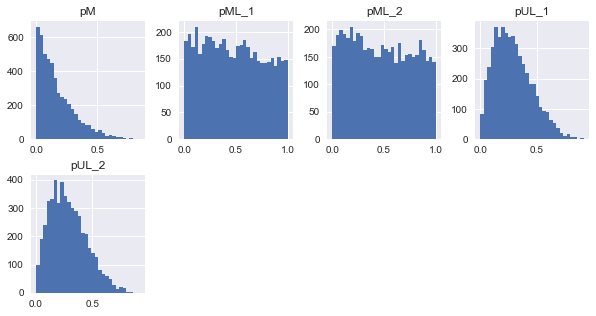

In [198]:
trace_burnt = trace[5000:9999]
hist_plot = trace_burnt.hist(bins=30,layout=(2,4))

### Comments

#### Sampling $I$

This method does not perform well, even when I impose strong priors and set initial parameter values equal to the truth.  

First, the posterior for $p_M$ is heavily skewed toward 1 when I sample $I$ using the formula in Step 1.  This corresponds with high posterior probabilities of $I(a,b)$, which may imply large false positive matching rates if threshold is set too low. 

This issue reflects the fact that updates to $(p_M, p_{M\ell}, p_{U\ell})$ depend on assignments of $I(a,b)$. The $sample_I$ function is too quick to assign matches.  This may result from the fact that I use two clusters, and that once $p_{U\ell}$ probabilities get set low, the chain cannot recover.  I test this issue by adding 1 to the denominator of the Bernoulli parameter in Step 1:

$$p \equiv Pr(\ I(a,b)^{(k+1)}=1\ |\ \gamma(a,b)) = Pr(\ M\  |\  \gamma(a,b)) = \frac{p_M^{(k)}Pr(\ \gamma(a,b)\ |\ M)}{Pr(\gamma(a,b)) + 1} $$ 

This change prevents $p_M$ from converging to 1 <span style="color:blue">(but I need to write more tests) </span>

#### Other bugs

My results are extremely sensitive to a choice of prior! Choosing the prior will be important to explore. 

Could I sample from the joint distribution of $(p_M, p_{M\ell}, p_{U\ell})\ | I$?  Could I model as Dirichlet?

Ultimately it is not worth the time and energy trying to fix this broken method so now I focus on the bipartite matching, which will fix many of these issues.

In [201]:
print(trace_burnt.median())
print('pM: ' + str(pM))
print('pML: ' + str(pML))
print('pUL: ' + str(pUL))
print('')
print(trace_burnt.std())


pM       0.129480
pML_1    0.463082
pML_2    0.467905
pUL_1    0.268405
pUL_2    0.266635
dtype: float64
pM: 0.2
pML: [1, 1]
pUL: [0.1, 0.1]

pM       0.147225
pML_1    0.286617
pML_2    0.290138
pUL_1    0.167161
pUL_2    0.163874
dtype: float64


In [202]:
i/niters

array([0.0383, 0.0383, 0.0391, 0.0404, 0.0358])